consider UK-DALE house-1 data first

select suitable range of data

Result should be a dataframe with column timestamp, and the resulting load.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os

In [2]:
house_1_folder = Path(Path(os.getcwd()).parent, 'datasets', 'UK-DALE-FULL-disaggregated', 'ukdale', 'house_1')

In [3]:
labels = open(house_1_folder / 'labels.dat').readlines()
labels = [l.strip().split(' ')[1] for l in labels]

In [4]:
labels

['aggregate',
 'boiler',
 'solar_thermal_pump',
 'laptop',
 'washing_machine',
 'dishwasher',
 'tv',
 'kitchen_lights',
 'htpc',
 'kettle',
 'toaster',
 'fridge',
 'microwave',
 'lcd_office',
 'hifi_office',
 'breadmaker',
 'amp_livingroom',
 'adsl_router',
 'livingroom_s_lamp',
 'soldering_iron',
 'gigE_&_USBhub',
 'hoover',
 'kitchen_dt_lamp',
 'bedroom_ds_lamp',
 'lighting_circuit',
 'livingroom_s_lamp2',
 'iPad_charger',
 'subwoofer_livingroom',
 'livingroom_lamp_tv',
 'DAB_radio_livingroom',
 'kitchen_lamp2',
 'kitchen_phone&stereo',
 'utilityrm_lamp',
 'samsung_charger',
 'bedroom_d_lamp',
 'coffee_machine',
 'kitchen_radio',
 'bedroom_chargers',
 'hair_dryer',
 'straighteners',
 'iron',
 'gas_oven',
 'data_logger_pc',
 'childs_table_lamp',
 'childs_ds_lamp',
 'baby_monitor_tx',
 'battery_charger',
 'office_lamp1',
 'office_lamp2',
 'office_lamp3',
 'office_pc',
 'office_fan',
 'LED_printer']

In [5]:
concerned_labels = [
    'aggregate',
    'washing_machine',
    'dishwasher',
    'fridge',
    'kettle',
    'microwave',
    'toaster',

    'tv',
    'htpc',
    # 'kitchen_radio',
    'gas_oven',

    'kitchen_lights',
]

In [6]:
# for each label, read the corresponding .dat file (should be a space-separated file)
# then combine all the data into a single DataFrame

data = {}
for label in concerned_labels:
    i = labels.index(label)
    file_path = house_1_folder / f'channel_{i+1}.dat'
    if file_path.exists():
        df = pd.read_csv(file_path, sep=' ', header=None)
        df.columns = ['timestamp', label]
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)        # UTC as the dataset is collected in UK
        df.reset_index(inplace=True)

        data[label] = df
    else:
        print(f"File {file_path} does not exist.")


---

(Optional) Data pre-filtering

We set a range and we only consider data within this range

Start with a subset of data to test with the overall data-preprocessing pipeline and model development. This can speed up the development process

In [7]:
from datetime import timezone

tz = timezone.utc  # Use UTC timezone for consistency

# start with a year-long dataset first
start_date = datetime(2013, 1, 1, tzinfo=tz)
end_date = datetime(2013, 12, 31, tzinfo=tz)

In [8]:
# filter each DataFrame to only include data within the specified date range

for label, df in data.items():
    data[label] = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

---

Data alignment

While this is not necessary for this project, it will be better in visualizing the load per appliance to the aggregated load

This allows intuitive comparison on how an appliance's individual load affecting the overall aggregated load

And help selecting aggregated load region for forming the environment

We make use of merge_asof func in pandas, and add a new column to each of the appliance's dataframe to indicate the mapped timestamp of that row

In [9]:
def align_with_aggregated_load_timestamp(appl_df, aggregated_load_timestamps, tolerance_sec=3):
    """
    Aligns the appliance's DataFrame with the aggregated load timestamps.
    
    Parameters:
    - appl_df: DataFrame of the appliance data
    - aggregated_load_timestamps: Series of aggregated load timestamps
    
    Returns:
    - DataFrame with aligned timestamps
    """
    return pd.merge_asof(
        aggregated_load_timestamps,
        appl_df,
        left_on='timestamp_aggregate',
        right_on='timestamp',
        direction='nearest',
        tolerance=tolerance_sec  # Allow a tolerance of +- 3 seconds
    )

In [10]:
aggregated_load_timestamps = data['aggregate']['timestamp']
# rename the column to 'timestamp_aggregate' for clarity
aggregated_load_timestamps = aggregated_load_timestamps.rename('timestamp_aggregate')


# align each appliance's DataFrame with the aggregated load timestamps
aligned_data = {}
for label, df in data.items():
    if label == 'aggregate':
        continue

    print(f"Aligning {label} with aggregated load timestamps...")

    aligned_df = align_with_aggregated_load_timestamp(df, aggregated_load_timestamps)
    aligned_data[label] = aligned_df

    # drop the index column as it is not needed
    aligned_data[label].drop(columns=['index'], inplace=True)


Aligning washing_machine with aggregated load timestamps...
Aligning dishwasher with aggregated load timestamps...
Aligning fridge with aggregated load timestamps...
Aligning kettle with aggregated load timestamps...
Aligning microwave with aggregated load timestamps...
Aligning toaster with aggregated load timestamps...
Aligning tv with aggregated load timestamps...
Aligning htpc with aggregated load timestamps...
Aligning gas_oven with aggregated load timestamps...
Aligning kitchen_lights with aggregated load timestamps...


In [11]:
aligned_data['fridge']

,timestamp_aggregate,timestamp,fridge,datetime
0,1356998401,1.356998e+09,89.0,2013-01-01 00:00:01+00:00
1,1356998407,1.356998e+09,89.0,2013-01-01 00:00:07+00:00
2,1356998413,1.356998e+09,88.0,2013-01-01 00:00:14+00:00
3,1356998419,1.356998e+09,89.0,2013-01-01 00:00:20+00:00
4,1356998426,1.356998e+09,89.0,2013-01-01 00:00:26+00:00
...,...,...,...,...
4688425,1388447975,1.388448e+09,0.0,2013-12-30 23:59:36+00:00
4688426,1388447981,1.388448e+09,0.0,2013-12-30 23:59:43+00:00
4688427,1388447987,NaN,NaN,NaT
4688428,1388447993,1.388448e+09,0.0,2013-12-30 23:59:51+00:00


---

Perform forward filling or data dropping if required

- Find gaps larger than 3 min, remove these gaps, and the whole day in which the gap exists.  
If the gap across two days, drop both days (or forward/backward fill the remaining empty segment)
- Forward fill the smaller gaps

In [12]:
def find_large_gaps(df, threshold = 180):
    """
    Finds large gaps in the DataFrame where the time difference between consecutive rows exceeds the threshold.
    
    Parameters:
    - df: DataFrame with a 'datetime' column
    - threshold: Time difference in seconds to consider as a large gap
    
    Returns:
    - List of indices where large gaps are found
    """
    time_diffs = df['datetime'].diff().dt.total_seconds()
    large_gap_indices = time_diffs[time_diffs > threshold].index.tolist()

    # for each large gap, compute the day it occurs in
    large_gap_days = df.loc[large_gap_indices, 'datetime'].dt.floor('D').unique()

    return large_gap_indices, large_gap_days

In [13]:
def find_small_gaps(df, threshold = 180):
    """
    Finds small gaps in the DataFrame where the time difference between consecutive rows is less than the threshold, but larger than 6 seconds.
    
    Parameters:
    - df: DataFrame with a 'datetime' column
    - threshold: Time difference in seconds to consider as a small gap
    
    Returns:
    - List of indices where small gaps are found
    """
    time_diffs = df['datetime'].diff().dt.total_seconds()
    small_gap_indices = time_diffs[(time_diffs < threshold) & (time_diffs > 6)].index.tolist()
    return small_gap_indices

In [14]:
aligned_data['washing_machine'].iloc[124892:124895]  # Example of accessing a specific row

,timestamp_aggregate,timestamp,washing_machine,datetime
124892,1357817536,1.357818e+09,0.0,2013-01-10 11:32:17+00:00
124893,1358444312,1.358444e+09,0.0,2013-01-17 17:38:34+00:00
124894,1358444319,1.358444e+09,0.0,2013-01-17 17:38:40+00:00


In [15]:
# remove large gaps for each appliance

all_large_gaps = {}
all_large_gaps_days = set()

for label, df in aligned_data.items():
    print(f"Finding large gaps in {label}...")
    large_gaps, large_gap_days = find_large_gaps(df)
    
    # Drop the rows with large gaps
    # aligned_data[label] = df.drop(index=large_gaps)
    
    # Optionally, you can also drop the entire day if a large gap exists
    # aligned_data[label] = aligned_data[label][~aligned_data[label]['datetime'].dt.floor('D').isin(large_gap_days)]

    all_large_gaps[label] = large_gaps
    all_large_gaps_days.update(large_gap_days)


Finding large gaps in washing_machine...
Finding large gaps in dishwasher...
Finding large gaps in fridge...
Finding large gaps in kettle...
Finding large gaps in microwave...
Finding large gaps in toaster...
Finding large gaps in tv...
Finding large gaps in htpc...
Finding large gaps in gas_oven...
Finding large gaps in kitchen_lights...


In [16]:
len(all_large_gaps_days)

28

For each of the large gap days, remove the data in each appliance's dataframe

In [17]:
for label, df in aligned_data.items():
    print(f"Removing days with large gap in {label}...")
    
    # remove the entire day if a large gap exists
    aligned_data[label] = aligned_data[label][~aligned_data[label]['datetime'].dt.floor('D').isin(all_large_gaps_days)]

Removing days with large gap in washing_machine...
Removing days with large gap in dishwasher...
Removing days with large gap in fridge...
Removing days with large gap in kettle...
Removing days with large gap in microwave...
Removing days with large gap in toaster...
Removing days with large gap in tv...
Removing days with large gap in htpc...
Removing days with large gap in gas_oven...
Removing days with large gap in kitchen_lights...


In [18]:
# also remove the large gaps from the aggregate data
print("Removing large gaps from aggregate data...")
aggregate_df = data['aggregate'].copy()
aggregate_df = aggregate_df[~aggregate_df['datetime'].dt.floor('D').isin(all_large_gaps_days)]

Removing large gaps from aggregate data...


The remaining gaps are smaller than 3 mins

We perform forward fill to these gaps (only the appliance's reading).

In [19]:
for label, df in aligned_data.items():
    print(f"Performing forward fill for {label}...")

    # forward fill the gaps in the appliance's reading
    df.loc[:, label] = df[label].ffill()

Performing forward fill for washing_machine...
Performing forward fill for dishwasher...
Performing forward fill for fridge...
Performing forward fill for kettle...
Performing forward fill for microwave...
Performing forward fill for toaster...
Performing forward fill for tv...
Performing forward fill for htpc...
Performing forward fill for gas_oven...
Performing forward fill for kitchen_lights...


In [20]:
aggregate_df

,index,timestamp,aggregate,datetime
431368,431368,1356998401,499,2013-01-01 00:00:01+00:00
431369,431369,1356998407,500,2013-01-01 00:00:07+00:00
431370,431370,1356998413,515,2013-01-01 00:00:13+00:00
431371,431371,1356998419,522,2013-01-01 00:00:19+00:00
431372,431372,1356998426,508,2013-01-01 00:00:26+00:00
...,...,...,...,...
5119793,5119793,1388447975,178,2013-12-30 23:59:35+00:00
5119794,5119794,1388447981,177,2013-12-30 23:59:41+00:00
5119795,5119795,1388447987,178,2013-12-30 23:59:47+00:00
5119796,5119796,1388447993,178,2013-12-30 23:59:53+00:00


In [21]:
aligned_data['dishwasher']

,timestamp_aggregate,timestamp,dishwasher,datetime
0,1356998401,1.356998e+09,1.0,2013-01-01 00:00:02+00:00
1,1356998407,1.356998e+09,1.0,2013-01-01 00:00:08+00:00
2,1356998413,1.356998e+09,1.0,2013-01-01 00:00:14+00:00
3,1356998419,1.356998e+09,1.0,2013-01-01 00:00:20+00:00
4,1356998426,1.356998e+09,1.0,2013-01-01 00:00:26+00:00
...,...,...,...,...
4688425,1388447975,1.388448e+09,1.0,2013-12-30 23:59:37+00:00
4688426,1388447981,NaN,1.0,NaT
4688427,1388447987,1.388448e+09,1.0,2013-12-30 23:59:45+00:00
4688428,1388447993,1.388448e+09,1.0,2013-12-30 23:59:53+00:00


In [22]:
aligned_data['washing_machine']

,timestamp_aggregate,timestamp,washing_machine,datetime
0,1356998401,1.356998e+09,0.0,2013-01-01 00:00:02+00:00
1,1356998407,1.356998e+09,0.0,2013-01-01 00:00:08+00:00
2,1356998413,1.356998e+09,0.0,2013-01-01 00:00:14+00:00
3,1356998419,1.356998e+09,0.0,2013-01-01 00:00:20+00:00
4,1356998426,1.356998e+09,0.0,2013-01-01 00:00:26+00:00
...,...,...,...,...
4688425,1388447975,NaN,0.0,NaT
4688426,1388447981,1.388448e+09,0.0,2013-12-30 23:59:39+00:00
4688427,1388447987,1.388448e+09,0.0,2013-12-30 23:59:46+00:00
4688428,1388447993,1.388448e+09,0.0,2013-12-30 23:59:54+00:00


---

Merge each appliance's load to the dataframe of the aggregated load

In [23]:
# seems have an extra column 'index' in the aggregate data, so we drop it
aggregate_df.drop(columns=['index'], inplace=True)

In [24]:
aggregate_df

,timestamp,aggregate,datetime
431368,1356998401,499,2013-01-01 00:00:01+00:00
431369,1356998407,500,2013-01-01 00:00:07+00:00
431370,1356998413,515,2013-01-01 00:00:13+00:00
431371,1356998419,522,2013-01-01 00:00:19+00:00
431372,1356998426,508,2013-01-01 00:00:26+00:00
...,...,...,...
5119793,1388447975,178,2013-12-30 23:59:35+00:00
5119794,1388447981,177,2013-12-30 23:59:41+00:00
5119795,1388447987,178,2013-12-30 23:59:47+00:00
5119796,1388447993,178,2013-12-30 23:59:53+00:00


In [25]:
aligned_data['washing_machine']

,timestamp_aggregate,timestamp,washing_machine,datetime
0,1356998401,1.356998e+09,0.0,2013-01-01 00:00:02+00:00
1,1356998407,1.356998e+09,0.0,2013-01-01 00:00:08+00:00
2,1356998413,1.356998e+09,0.0,2013-01-01 00:00:14+00:00
3,1356998419,1.356998e+09,0.0,2013-01-01 00:00:20+00:00
4,1356998426,1.356998e+09,0.0,2013-01-01 00:00:26+00:00
...,...,...,...,...
4688425,1388447975,NaN,0.0,NaT
4688426,1388447981,1.388448e+09,0.0,2013-12-30 23:59:39+00:00
4688427,1388447987,1.388448e+09,0.0,2013-12-30 23:59:46+00:00
4688428,1388447993,1.388448e+09,0.0,2013-12-30 23:59:54+00:00


The right merge should keep each timestamp has a record for every appliance (either with value, or NaN)

In [26]:
# perform merge with aggregate dataframe

for label, df in aligned_data.items():
    if label == 'aggregate':
        continue

    print(f"Merging {label} with aggregate data...")

    # merge the aligned appliance's df with the aggregate df
    aggregate_df = aggregate_df.merge(
        df,
        left_on='timestamp',
        right_on='timestamp_aggregate',
        how='right',
        suffixes=('', f'_{label}')  # to avoid column name conflicts
    )

Merging washing_machine with aggregate data...
Merging dishwasher with aggregate data...
Merging fridge with aggregate data...
Merging kettle with aggregate data...
Merging microwave with aggregate data...
Merging toaster with aggregate data...
Merging tv with aggregate data...
Merging htpc with aggregate data...
Merging gas_oven with aggregate data...
Merging kitchen_lights with aggregate data...


Again, check if there are gaps > 3 min

In [27]:
large_gaps_indices, large_gap_days = find_large_gaps(aggregate_df)

In [28]:
large_gap_days

<DatetimeArray>
['2013-02-18 00:00:00+00:00', '2013-03-19 00:00:00+00:00',
 '2013-03-20 00:00:00+00:00', '2013-05-17 00:00:00+00:00']
Length: 4, dtype: datetime64[ns, UTC]

In [29]:
small_gaps = find_small_gaps(aggregate_df)

In [30]:
len(small_gaps)

646959

In [31]:
# compute the mean gap size of the aggregated dataframe of small gaps
time_diffs = aggregate_df['datetime'].diff().dt.total_seconds()
small_gap = time_diffs[(time_diffs < 180) & (time_diffs > 6)]
mean_small_gap = small_gap.mean()
print(f"Mean small gap size: {mean_small_gap} seconds")
median_small_gap = small_gap.median()
print(f"Median small gap size: {median_small_gap} seconds")

Mean small gap size: 7.747764541493356 seconds
Median small gap size: 7.0 seconds


The small gaps are acceptable (as it is sampling error)

We remove the days with large gaps  
While this is not the best practice (there should be better ways to handle that), removing the days with large gaps is easy to implement.

In [32]:
# remove the large gaps from the aggregate data
aggregate_df = aggregate_df[~aggregate_df['datetime'].dt.floor('D').isin(large_gap_days)]

Perform column cleaning on the aggregate_df

In [33]:
aggregate_df.columns

Index(['timestamp', 'aggregate', 'datetime', 'timestamp_aggregate',
       'timestamp_washing_machine', 'washing_machine',
       'datetime_washing_machine', 'timestamp_aggregate_dishwasher',
       'timestamp_dishwasher', 'dishwasher', 'datetime_dishwasher',
       'timestamp_aggregate_fridge', 'timestamp_fridge', 'fridge',
       'datetime_fridge', 'timestamp_aggregate_kettle', 'timestamp_kettle',
       'kettle', 'datetime_kettle', 'timestamp_aggregate_microwave',
       'timestamp_microwave', 'microwave', 'datetime_microwave',
       'timestamp_aggregate_toaster', 'timestamp_toaster', 'toaster',
       'datetime_toaster', 'timestamp_aggregate_tv', 'timestamp_tv', 'tv',
       'datetime_tv', 'timestamp_aggregate_htpc', 'timestamp_htpc', 'htpc',
       'datetime_htpc', 'timestamp_aggregate_gas_oven', 'timestamp_gas_oven',
       'gas_oven', 'datetime_gas_oven', 'timestamp_aggregate_kitchen_lights',
       'timestamp_kitchen_lights', 'kitchen_lights',
       'datetime_kitchen_lights']

In [34]:
# keep only columns that are not 'timestamp_*'
aggregate_df = aggregate_df.loc[:, ~aggregate_df.columns.str.startswith('timestamp_')]

# remove columns with 'datetime_*' prefixes (these are the appliance's data timestamps)
aggregate_df = aggregate_df.loc[:, ~aggregate_df.columns.str.startswith('datetime_')]

In [35]:
# reset index
aggregate_df.reset_index(drop=True, inplace=True)

In [36]:
aggregate_df

,timestamp,aggregate,datetime,washing_machine,dishwasher,fridge,kettle,microwave,toaster,tv,htpc,gas_oven,kitchen_lights
0,1.356998e+09,499.0,2013-01-01 00:00:01+00:00,0.0,1.0,89.0,1.0,1.0,0.0,89.0,69.0,NaN,0.0
1,1.356998e+09,500.0,2013-01-01 00:00:07+00:00,0.0,1.0,89.0,1.0,1.0,0.0,89.0,69.0,NaN,0.0
2,1.356998e+09,515.0,2013-01-01 00:00:13+00:00,0.0,1.0,88.0,1.0,1.0,0.0,125.0,70.0,NaN,0.0
3,1.356998e+09,522.0,2013-01-01 00:00:19+00:00,0.0,1.0,89.0,1.0,1.0,0.0,91.0,70.0,NaN,0.0
4,1.356998e+09,508.0,2013-01-01 00:00:26+00:00,0.0,1.0,89.0,1.0,1.0,0.0,93.0,69.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341544,1.388448e+09,178.0,2013-12-30 23:59:35+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
4341545,1.388448e+09,177.0,2013-12-30 23:59:41+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
4341546,1.388448e+09,178.0,2013-12-30 23:59:47+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
4341547,1.388448e+09,178.0,2013-12-30 23:59:53+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0


Plot the dataframe with seaborn to show how each appliance contribute to the total load

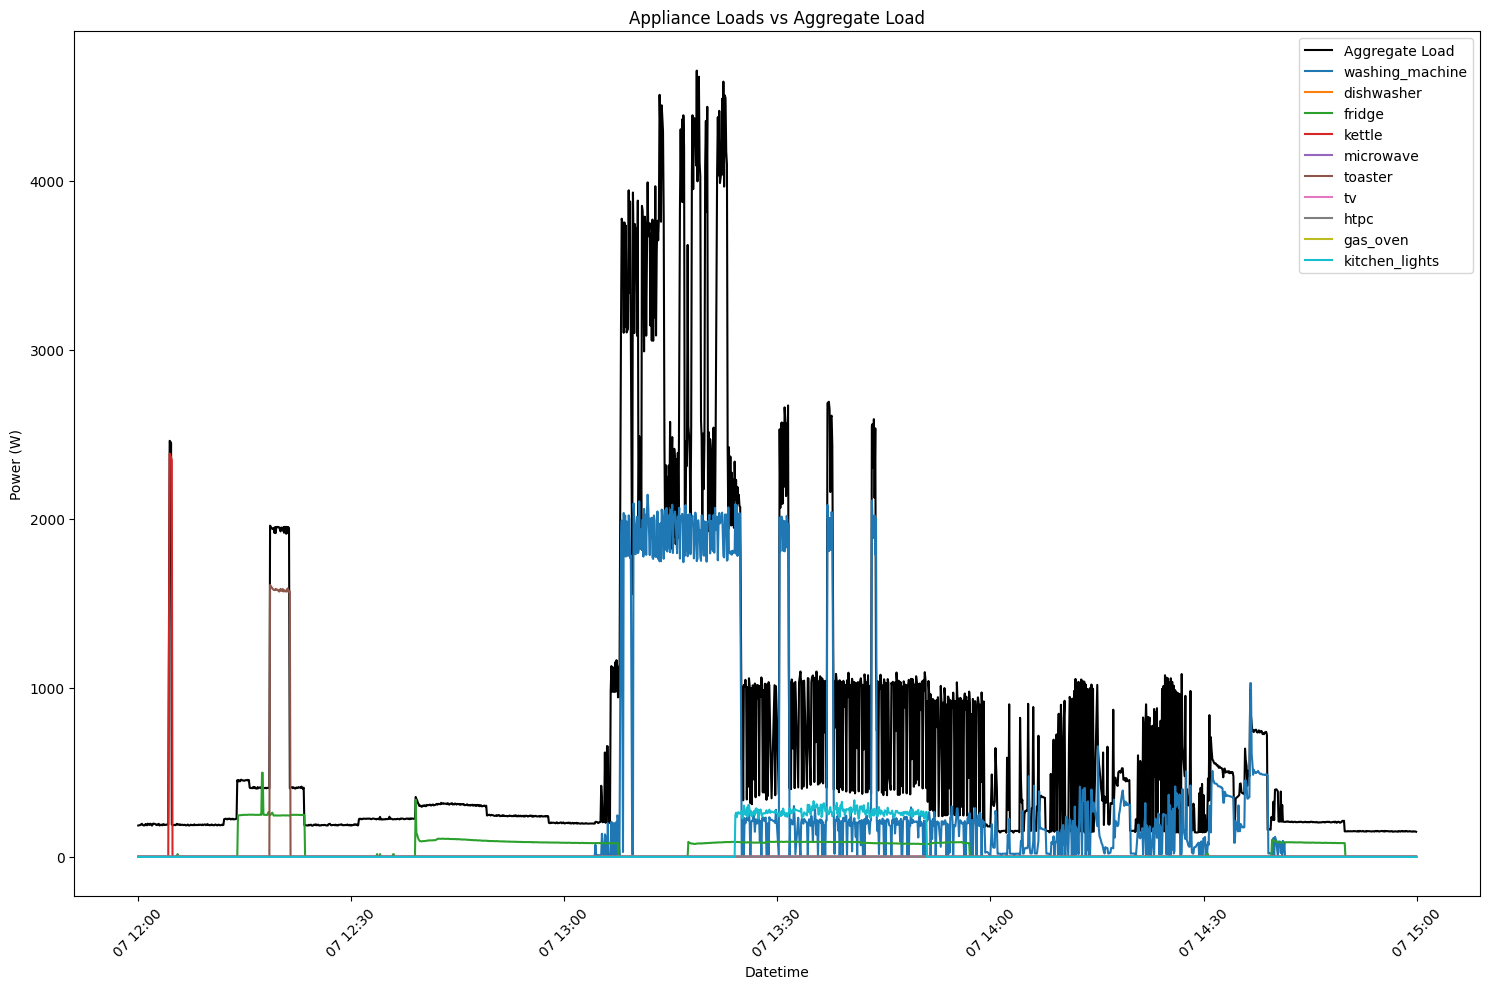

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the dataframe with seaborn to show how each appliance contributes to the total load

plt_start_datetime = datetime(2013, 3, 7, 12, 0, 0, tzinfo=tz)
plt_delta = timedelta(hours=3)

plt.figure(figsize=(15, 10))
sns.lineplot(data=aggregate_df[aggregate_df['datetime'].between(plt_start_datetime, plt_start_datetime + plt_delta)], x='datetime', y='aggregate', label='Aggregate Load', color='black')
for label in concerned_labels:
    if label == 'aggregate':
        continue
    sns.lineplot(data=aggregate_df[aggregate_df['datetime'].between(plt_start_datetime, plt_start_datetime + plt_delta)], x='datetime', y=label, label=label)
plt.title('Appliance Loads vs Aggregate Load')
plt.xlabel('Datetime')
plt.ylabel('Power (W)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

Identify date segments. This can be useful in randomizing the environment setup process for each epsiode.

In [38]:
# identify date segments of the merged df
# return a list of [start datetime, end datetime] for each segment

def identify_date_segments(df):
    """
    Identify date segments in the DataFrame.
    
    Parameters:
    - df: DataFrame with a 'datetime' column
    
    Returns:
    - List of tuples with (start_datetime, end_datetime) for each segment
    """
    
    # we first find the unique days in the 'datetime' column
    unique_days = df['datetime'].dt.floor('D').unique()

    # from unique days, we create a list of segments
    # by set difference between all dates within the range, and the unique days
    if len(unique_days) == 0:
        return []
    
    all_dates = set(pd.date_range(start=unique_days[0], end=unique_days[-1], freq='D'))
    missing_dates = all_dates - set(unique_days)

    # create date segments by walking through the all dates
    segments = []
    start_datetime = unique_days[0]
    for date in pd.date_range(start=unique_days[1], end=unique_days[-1], freq='D'):
        if date in missing_dates:
            end_datetime = date - timedelta(seconds=1)

            # consecutive missing dates
            if end_datetime.date() <= start_datetime.date():
                start_datetime = date + timedelta(days=1)
                continue

            segments.append((start_datetime, end_datetime))     # valid segment
            start_datetime = date + timedelta(days=1)
            
    # add the last segment
    end_datetime = unique_days[-1]
    if end_datetime >= start_datetime:
        segments.append((start_datetime, end_datetime))
    else:
        print(f"Warning: Last segment start {start_datetime} is after end {end_datetime}. Skipping last segment.")

    return segments, missing_dates


In [39]:
date_segments, missing_dates = identify_date_segments(aggregate_df)

In [40]:
date_segments

[(Timestamp('2013-01-01 00:00:00+0000', tz='UTC'),
  Timestamp('2013-01-06 23:59:59+0000', tz='UTC')),
 (Timestamp('2013-01-08 00:00:00+0000', tz='UTC'),
  Timestamp('2013-01-10 23:59:59+0000', tz='UTC')),
 (Timestamp('2013-01-26 00:00:00+0000', tz='UTC'),
  Timestamp('2013-01-28 23:59:59+0000', tz='UTC')),
 (Timestamp('2013-02-14 00:00:00+0000', tz='UTC'),
  Timestamp('2013-02-17 23:59:59+0000', tz='UTC')),
 (Timestamp('2013-02-21 00:00:00+0000', tz='UTC'),
  Timestamp('2013-02-24 23:59:59+0000', tz='UTC')),
 (Timestamp('2013-02-27 00:00:00+0000', tz='UTC'),
  Timestamp('2013-03-10 23:59:59+0000', tz='UTC')),
 (Timestamp('2013-03-16 00:00:00+0000', tz='UTC'),
  Timestamp('2013-03-18 23:59:59+0000', tz='UTC')),
 (Timestamp('2013-03-22 00:00:00+0000', tz='UTC'),
  Timestamp('2013-03-26 23:59:59+0000', tz='UTC')),
 (Timestamp('2013-03-28 00:00:00+0000', tz='UTC'),
  Timestamp('2013-04-10 23:59:59+0000', tz='UTC')),
 (Timestamp('2013-04-12 00:00:00+0000', tz='UTC'),
  Timestamp('2013-05-1

In [41]:
missing_dates

{Timestamp('2013-01-07 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-11 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-12 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-13 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-14 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-15 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-16 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-17 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-18 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-19 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-20 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-21 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-22 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-23 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-24 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-25 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-29 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-30 00:00:00+0000', tz='UTC'),
 Timestamp('2013-01-31 00:00:00+0000', tz='UTC'),
 Timestamp('2013-02-01 00:00:00+0000', tz='UTC'),


---

Save the dataset, together with the identified date segments

In [42]:
from pathlib import Path

tdy = datetime.now().strftime('%Y%m%d')

dataset_folder = Path('dataset', tdy)

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

In [43]:
# save the dataset (in pkl format)
aggregate_df.to_pickle(dataset_folder / 'aggregate_df.pkl')
# save the date segments
with open(dataset_folder / 'date_segments.txt', 'w') as f:
    for start, end in date_segments:
        f.write(f"{start.isoformat()} - {end.isoformat()}\n")

---

We leave some of the data pre-processing (i.e. standardization, normalization) to the environment as in a previous paper, we may feed them as part of the state (or encode them as a vector) to tackle with the shifting distribution problem of each episode.